In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [241]:
plt.rcParams['figure.figsize'] = [10, 5]

In [419]:
j_faults = pd.read_csv('data/J1939Faults.csv').reset_index(drop = True)
onboard_data = pd.read_csv('data/VehicleDiagnosticOnboardData.csv').reset_index(drop=True)
fault_codes = pd.read_csv('data/Service_Fault_Codes_1_0_0_167.csv').reset_index(drop=True)
vehicle = pd.read_csv('data/Vehicle_Make.csv').reset_index(drop=True)

C:\Users\cmerr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Turn onboard data into a dataframe where each fault instance has one row. It is grouped on the FaultId which maps 1-to-1 on the RecordID.

In [420]:
ob_data = onboard_data.pivot(index='FaultId', columns='Name',values = 'Value').rename_axis(None)
pd.set_option('display.max_columns', None)
ob_data.reset_index(inplace=True)
ob_data = ob_data.rename(columns = {'index':'FaultId'})

Merge the on_data with the J1939 dataframe using the RecordID and FaultID.

In [421]:
ob_faults = pd.merge(j_faults, ob_data, how='left', left_on='RecordID', right_on='FaultId')

Sums up the number of null values in a row

In [423]:
ob_faults['null_count'] = ob_faults.isnull().sum(axis=1)

Corrects the datatype in certain rows

In [424]:
problem_cols = ['AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure']
for x in problem_cols:
    try:
        ob_faults[x] = ob_faults[x].str.replace(',','').astype(float)
    except ValueError:
        ob_faults[x] = ob_faults[x]
ob_faults['EventTimeStamp'] =  pd.to_datetime(ob_faults['EventTimeStamp'], format='%Y%m%d %H:%M:%S.%f')

Adds a check for instances where the location is in the values Big G instructed us to ignore.

In [425]:
ob_faults['repair_center'] = False
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.4347\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.0666\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.4438\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'35.5883\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-83.1747\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.1950\d+')), 'repair_center'] = True
ob_faults = ob_faults[ob_faults['repair_center']==False]

Removes instances where the EquipmentID is more than 5 characters (instructions from Big G)

In [429]:
ob_faults['EquipmentID_count'] = ob_faults['EquipmentID'].astype(str).str.len() 
ob_faults = ob_faults[ob_faults['EquipmentID_count'] < 6]

<ipython-input-429-9c0ad62aab82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_faults['EquipmentID_count'] = ob_faults['EquipmentID'].astype(str).str.len()


In [430]:
combined_df = ob_faults.drop(columns=['actionDescription','EquipmentID_count','repair_center','faultValue'])

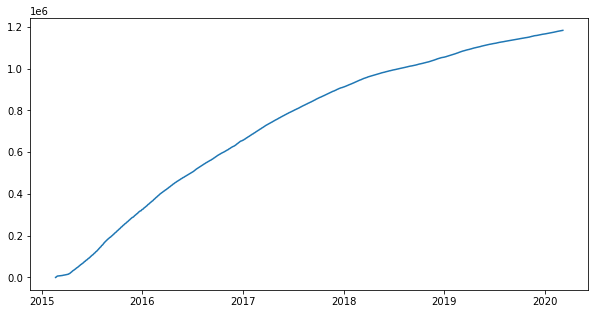

In [433]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]
time_sorted = five_years[['EventTimeStamp']]
time_sorted = time_sorted.sort_values(by=['EventTimeStamp']).reset_index(drop=True)
y = time_sorted.index.tolist()
x = time_sorted['EventTimeStamp']
plt.plot(x,y)
plt.show()

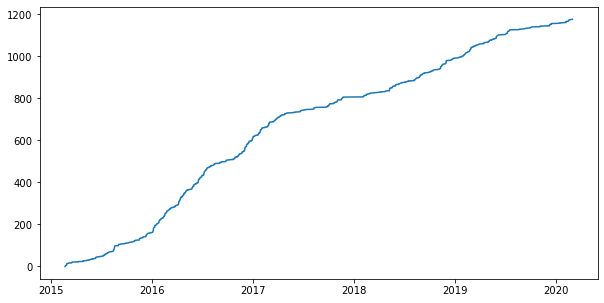

In [435]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]
derate_five = five_years[five_years['spn']==5246]
time_sorted = derate_five[['EventTimeStamp']]
time_sorted = time_sorted.sort_values(by=['EventTimeStamp']).reset_index(drop=True)
y = time_sorted.index.tolist()
x = time_sorted['EventTimeStamp']
plt.plot(x,y)
plt.show()

In [436]:
combined_df['Month'] = pd.DatetimeIndex(combined_df['EventTimeStamp']).month

array([[<AxesSubplot:title={'center':'Month'}>]], dtype=object)

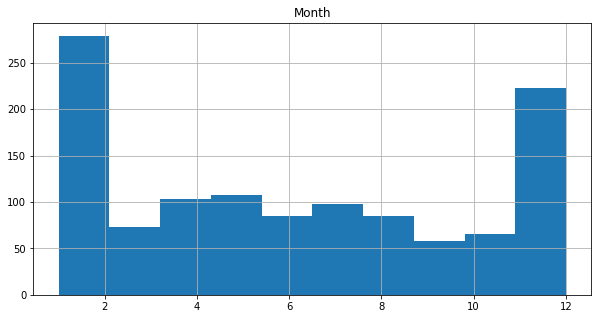

In [446]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]

derate_five = five_years[five_years['spn']==5246]

time_sorted = derate_five[['Month']]
monthprint = derate_five.groupby('Month').count()
derate_five.hist(column='Month')

In [450]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]

derate_five = five_years[five_years['spn']==5246]

derate_five.groupby("Month").count()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,118,118,118,0,92,91,91,91,118,118,118,118,118,118,118,118,118,118,118,35,59,25,25,54,59,59,59,58,59,46,59,59,59,39,59,59,118,15,0,57,34,13,58,118
2,161,161,161,0,136,128,135,135,161,161,161,161,161,161,161,161,161,161,161,67,78,64,66,78,78,76,78,75,78,68,77,79,76,36,85,78,161,35,0,75,14,43,76,161
3,73,73,73,0,65,63,69,69,73,73,73,73,73,73,73,73,73,73,73,29,34,32,32,34,34,34,34,33,34,32,31,33,34,10,38,34,73,17,0,34,2,17,34,73
4,103,103,103,0,73,73,74,74,103,103,103,103,103,103,103,103,103,103,103,33,50,24,26,46,50,49,50,47,50,39,48,45,48,30,52,50,103,12,0,48,25,13,48,103
5,108,108,108,0,77,76,76,76,108,108,108,108,108,108,108,108,108,108,108,39,52,33,35,46,52,50,49,50,52,46,52,52,50,32,55,52,108,32,0,50,20,31,50,108
6,85,85,85,0,72,72,72,72,85,85,85,85,85,85,85,85,85,85,85,30,39,28,28,37,39,39,39,39,39,35,36,39,39,18,42,39,85,14,0,39,14,12,39,85
7,98,98,98,0,91,85,85,85,98,98,98,98,98,98,98,98,98,98,98,34,40,30,31,39,40,39,40,39,40,35,38,39,39,24,50,40,98,17,0,39,9,22,39,98
8,85,85,85,0,63,62,70,70,85,85,85,85,85,85,85,85,85,85,85,27,30,26,26,29,30,30,30,30,30,28,27,31,30,17,44,30,85,22,0,30,5,22,30,85
9,58,58,58,0,58,53,53,53,58,58,58,58,58,58,58,58,58,58,58,23,28,26,26,26,28,28,28,27,28,28,23,28,28,12,28,28,58,18,0,27,2,15,28,58


In [448]:
combined_df[(combined_df['EventTimeStamp'] < '2018-01-01') & (combined_df['EventTimeStamp'] > '2016-01-01')]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month
325794,330851,6613147,2016-01-01 00:06:01,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,False,126,1610,105415630,35.653287,-80.459120,2016-01-01 00:05:56.000,330851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1
325795,330852,6613188,2016-01-01 00:21:57,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,False,126,1605,105415080,30.679166,-81.458425,2016-01-01 00:21:52.000,330852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1
325796,330853,6613191,2016-01-01 00:22:29,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,True,126,1605,105415080,30.679074,-81.459212,2016-01-01 00:23:04.000,330853,0.0,14.7175,False,66.48672,341299.40,181.4,14.0,22.62,202.04370,601.125,6737.50,NaN,48431.718981,0.647223,32.0,True,131.0,1279.0,False,NaN,4.407852,NaN,100.0,0.58,5,1
325797,330854,6613215,2016-01-01 00:30:57,Low (Severity Low) Engine Coolant Level,05317106*05005224*050815201656*09400035*G1*BDR*,79845785,6X1u13D1500000000,CMMNS,0,111,17,True,126,1814,105369518,36.066435,-86.435138,2016-01-01 00:31:33.000,330854,15.2,14.5725,False,64.62260,55734.76,107.6,16.0,42.92,99.21875,748.750,1078.65,100.0,7649.630110,1.320864,32.0,True,89.6,1023.0,NaN,NaN,1.980621,NaN,100.0,0.29,5,1
325798,330855,6613252,2016-01-01 00:43:16,High (Severity Medium) Aftertreatment 1 Partic...,04993120*00040893*082113134117*07700053*I0*BBZ*,79476012,6X1u10D1500000000,CMMNS,0,3251,16,False,1,1454,105358372,30.251388,-82.517731,2016-01-01 00:43:11.000,330855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913132,938944,35911041,2017-12-31 21:55:50,Low (Severity Medium) Engine Coolant Level,04358814*06163860*061516161145*09401661*G1*BDR*,79951760,6X1u13D1500000000,CMMNS,0,111,18,True,2,2011,105437762,36.744212,-80.772870,2017-12-31 21:58:27.000,938944,0.0,13.4850,False,66.48672,101241.70,35.6,23.0,45.82,40.66250,800.750,2016.95,24.0,14013.006498,1.915253,NaN,True,23.0,2047.0,True,NaN,0.000000,NaN,100.0,0.87,5,12
913133,938945,35911078,2017-12-31 22:00:48,Low (Severity Medium) Engine Coolant Level,04358814*06163860*061516161145*09401661*G1*BDR*,79951760,6X1u13D1500000000,CMMNS,0,111,18,False,2,2011,105437762,36.744212,-80.772870,2017-12-31 22:00:43.000,938945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,12
913248,939060,35935793,2017-12-31 12:38:04,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,True,126,1609,105415391,27.964027,-82.407314,2018-01-01 00:07:31.000,939060,5.6,14.7175,False,64.62260,604658.30,183.2,0.0,36.54,193.38130,963.750,13233.30,39.2,86020.231916,0.000000,NaN,True,136.4,1279.0,False,NaN,12.670150,NaN,100.0,1.16,5,12
914191,940951,36080560,2017-12-29 11:55:15,Abnormal Update Rate Tire Location,NaN,NaN,CECU3B-NAMUX4,PACCR,49,929,9,True,126,1610,105334108,36.194166,-83.174907,2018-01-03 10:34:48.000,940951,22.8,14.2825,False,64.62260,550684.10,185.0,6.0,37.12,203.28130,1070.625,10962.15,100.0,76440.824967,0.845353,32.0,True,104.0,1279.0,False,NaN,5.038932,NaN,100.0,1

In [322]:
combined_df[combined_df['EquipmentID']==1393]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count
50849,51961,2412662,2015-05-13 16:35:56,Low (Severity Low) Catalyst Tank Level,unknown,unknown,unknown,unknown,0,1761,17,True,1,1393,105356577,36.911574,-86.435277,2015-05-13 16:36:32.000,51961,NaN,14.5000,False,66.48672,460220.0,188.6,100.0,26.68,216.7250,975.250,9612.80,57.2,70300.806048,9.510223,NaN,True,100.4,1023.0,NaN,-99813.960938,23.44705,3276.75,NaN,8.12,6
51262,52374,2419123,2015-05-14 04:50:28,Low (Severity Low) Catalyst Tank Level,unknown,unknown,unknown,unknown,0,1761,17,False,1,1393,105356577,36.661805,-86.553333,2015-05-14 04:50:23.000,52374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
110622,113008,3337976,2015-07-07 14:03:00,Low (Severity Low) Catalyst Tank Level,unknown,unknown,unknown,unknown,0,1761,17,True,1,1393,105356577,34.909074,-85.114305,2015-07-07 14:03:36.000,113008,NaN,14.3550,True,64.62260,473629.2,195.8,0.0,37.12,224.1500,1488.625,9881.90,24.4,72215.921339,0.000000,NaN,True,116.6,1023.0,NaN,42203.531250,69.36056,3276.75,NaN,2.03,6
110708,113094,3339092,2015-07-07 14:51:59,Low (Severity Low) Catalyst Tank Level,unknown,unknown,unknown,unknown,0,1761,17,False,1,1393,105356577,35.152685,-84.953703,2015-07-07 14:51:55.000,113094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
115822,118208,3412912,2015-07-11 04:37:36,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,17,True,1,1393,105356577,35.197361,-85.814166,2015-07-11 04:38:13.000,118208,NaN,13.9925,False,64.62260,475092.0,186.8,0.0,37.12,215.8813,1470.000,9912.15,73.2,72442.845132,0.000000,NaN,True,91.4,1023.0,NaN,40740.203125,50.23398,3276.75,NaN,27.55,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411789,420056,8082713,2016-03-17 14:36:44,Condition Exists Engine Coolant Temperature,04993120*00027521*040213150018*07700044*I0*BBZ*,79464675,6X1u10D1500000000,CMMNS,0,110,31,False,1,1393,105406640,35.224768,-85.808379,2016-03-17 14:36:40.000,420056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
411792,420059,8082742,2016-03-17 14:37:21,Low (Severity Low) Engine Coolant Level,04993120*00027521*040213150018*07700044*I0*BBZ*,79464675,6X1u10D1500000000,CMMNS,0,111,17,False,1,1393,105406640,35.224814,-85.808287,2016-03-17 14:37:17.000,420059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
411861,420128,8084453,2016-03-17 15:47:19,Low (Severity Low) Engine Coolant Level,04993120*00027521*040213150018*07700044*I0*BBZ*,79464675,6X1u10D1500000000,CMMNS,0,111,17,True,1,1393,105406640,35.224814,-85.808333,2016-03-17 15:47:55.000,420128,0.0,13.7750,False,64.62260,539175.4,168.8,18.0,20.30,185.7875,651.625,11215.80,78.4,82152.753075,1.030274,NaN,False,123.8,1023.0,NaN,-23770.554688,0.00000,3276.75,NaN,0.87,5
411878,420145,8084885,2016-03-17 16:10:42,Low (Severity Low) Engine Coolant Level,04993120*00027521*040213150018*07700044*I0*BBZ*,79464675,6X1u10D1500000000,CMMNS,0,111,17,False,1,1393,105406640,35.224814,-85.808287,2016-03-17 16:10:38.000,420145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25


In [313]:
combined_df[combined_df['activeTransitionCount']<1]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count
371,372,995142,2015-02-21 17:00:26,Not Reporting Data Aftertreatment 1 Fuel Enabl...,unknown,unknown,unknown,unknown,0,3482,7,False,0,1657,105420592,36.066712,-86.434675,2015-02-21 16:51:11.000,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21503.0,NaN,NaN,NaN,NaN,NaN,NaN,25
372,373,995143,2015-02-21 17:00:26,Low (Severity Medium) Engine Injector Metering...,unknown,unknown,unknown,unknown,0,157,18,False,0,1657,105420592,36.066712,-86.434675,2015-02-21 16:51:11.000,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21503.0,NaN,NaN,NaN,NaN,NaN,NaN,25
4334,4335,1049783,2015-02-24 14:38:29,NaN,04993120*00017231*040213150018*07700044*I0*BBZ*,79461374,6X1u10D1500000000,CMMNS,0,5319,31,False,0,1372,105351194,38.349120,-85.708981,2015-02-24 14:38:25.000,4335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,26
5123,5124,1061719,2015-02-25 07:46:58,NaN,04993120*00022630*082113134117*07700053*I0*BBZ*,79463845,6X1u10D1500000000,CMMNS,0,4364,18,False,0,1429,105356054,36.066805,-86.434722,2015-02-25 07:37:16.000,5124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035.0,NaN,NaN,NaN,NaN,NaN,NaN,26
8759,8760,1326983,2015-03-12 16:41:29,Incorrect Data Engine Intake Manifold #1 Pressure,04993120*00000552*042114185815*07700062*I0*BBZ*,79452480,6X1u10D1500000000,CMMNS,0,102,2,False,0,1368,105338729,40.841435,-74.021898,2015-03-12 16:41:24.000,8760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185770,1246894,123089150,2020-03-01 11:08:02,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,36.194212,-83.174907,2020-03-01 11:08:37.000,1246894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,24
1186652,1247776,123554597,2020-03-04 13:30:58,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,36.660324,-86.555740,2020-03-04 13:31:35.000,1247776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,24
1186750,1247874,123606252,2020-03-04 19:14:22,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,False,0,1826,105416377,35.978564,-85.016018,2020-03-04 19:14:18.000,1247874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25
1186986,1248110,123728935,2020-03-05 13:19:08,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,36.759074,-86.170787,2020-03-05 13:19:43.000,1248110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,24
